In [1]:
# ==============================================================
# קוד מלא למודל MSFlow עם Focal + Center + Margin Loss
# ==============================================================
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score, precision_recall_curve, roc_curve,precision_score, recall_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from glob import glob
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# ========================== Dataset ===========================
def collect_paths(subset_dir):
    paths = []
    for label in ['good', 'ungood']:
        full_path = os.path.join(subset_dir, label)
        if os.path.exists(full_path):
            paths += glob(os.path.join(full_path, '*'))
    return paths

class CamelyonDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.paths = collect_paths(root_dir)
        self.labels = [1 if 'ungood' in p.lower() else 0 for p in self.paths]
        self.transform = transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        img = self.transform(image=np.array(img))['image']
        label = torch.tensor(self.labels[idx])
        return img, label

# ====================== Augmentations =========================
def get_transforms(train=True):
    if train:
        return A.Compose([
           A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.33)),
            A.HorizontalFlip(),
            A.ColorJitter(),
            A.Normalize(),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(224, 224),
            A.Normalize(),
            ToTensorV2()
        ])

# ============================ SE ==============================
class SEModule(nn.Module):
    def __init__(self, ch, r=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(ch, ch // r, bias=False),
            nn.ReLU(),
            nn.Linear(ch // r, ch, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.fc(self.pool(x).view(b, c)).view(b, c, 1, 1)
        return x * y.expand_as(x)

# ============================ FPN =============================
class FPN(nn.Module):
    def __init__(self, in_chs, out_ch):
        super().__init__()
        self.lateral = nn.ModuleList([nn.Conv2d(c, out_ch, 1) for c in in_chs])
        self.outs = nn.ModuleList([nn.Conv2d(out_ch, out_ch, 3, padding=1) for _ in in_chs])

    def forward(self, feats):
        feats = [l(f) for l, f in zip(self.lateral, feats)]
        for i in range(len(feats) - 1, 0, -1):
            feats[i-1] += F.interpolate(feats[i], scale_factor=2, mode='nearest')
        return [o(f) for o, f in zip(self.outs, feats)]

# ========================= Glow Block =========================
class GlowBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(ch, ch, 1),
            nn.GroupNorm(4, ch),
            nn.ReLU()
        )

    def forward(self, x): return self.block(x)

# ========================= MSFlow Model =======================
class MSFlow(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.stem = nn.Sequential(
                    base.conv1,
                    base.bn1,
                    base.relu,
                    base.maxpool
                                )
        self.l1 = nn.Sequential(base.layer1, SEModule(64))
        self.l2 = nn.Sequential(base.layer2, SEModule(128))
        self.l3 = nn.Sequential(base.layer3, SEModule(256))
        self.l4 = nn.Sequential(base.layer4, SEModule(512))

        self.fpn = FPN([64,128,256,512], 128)
        self.flow = nn.ModuleList([GlowBlock(128) for _ in range(4)])
        self.weights = nn.Parameter(torch.ones(4))

        self.clf = nn.Sequential(
            nn.Linear(128*4, 64),
            nn.ReLU(),
            nn.LayerNorm(64),    # הוספה מועילה
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.stem(x)
        f1 =  self.l1(x)
        f2 =  self.l2(f1)
        f3 = self.l3(f2)
        f4 = self.l4(f3)
        feats = self.fpn([f1,f2,f3,f4])
        feats = [F.avg_pool2d(f, kernel_size=2) for f in feats]  # הפחתת הרזולוציה
        flows = [g(f) for g, f in zip(self.flow, feats)]
        target_size = flows[0].shape[2:]
        flows = [F.interpolate(f, size=target_size, mode='nearest') for f in flows]
        emb = torch.cat([F.adaptive_avg_pool2d(f, 1).flatten(1) for f in flows], dim=1)
        emb = F.normalize(emb, p=2, dim=1)
        score = self.clf(emb).squeeze(1)
        return emb, score

# ======================== Loss Functions ======================
class CenterLoss(nn.Module):
    def __init__(self, num_classes=2, feat_dim=512):
        super().__init__()
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))

    def forward(self, x, y):
        centers_batch = self.centers.to(y.device)[y]
        dists = ((x - centers_batch) ** 2).sum(dim=1)
        return dists.mean()

# 🟣 Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma

    def forward(self, logits, y):
        BCE = F.binary_cross_entropy_with_logits(logits, y.float(), reduction='none')
        pt = torch.exp(-BCE)
        return ((1 - pt) ** self.gamma * BCE).mean()

# 🔴 Margin Loss
class MarginLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, x, y):
        dist_matrix = torch.cdist(x, x, p=2)  # מרחקים ל-2-norm
        y = y.view(-1, 1)

        mask_pos = (y == y.T).float()
        mask_neg = (y != y.T).float()

        # מציאת המרחקים הממוצעים בין חיוביים ושליליים
        pos_dist = (dist_matrix * mask_pos).sum() / mask_pos.sum().clamp(min=1.0)
        neg_dist = (dist_matrix * mask_neg).sum() / mask_neg.sum().clamp(min=1.0)

        loss = F.relu(self.margin - neg_dist + pos_dist)
        return loss

# 🟡 Combined Loss
class CombinedLoss(nn.Module):
    def __init__(self, margin=0.5, center_weight=0.1, margin_weight=0.1, feat_dim=512):
        super().__init__()
        self.focal = FocalLoss()
        self.center = CenterLoss(num_classes=2, feat_dim=feat_dim)
        self.margin = MarginLoss(margin)
        self.center_weight = center_weight
        self.margin_weight = margin_weight

    def forward(self, emb, logits, y):
        # focal loss
        focal = self.focal(logits, y)

        # center loss
        center_val = self.center(emb, y)  # עכשיו הוא מחזיר רק ערך אחד

        # margin loss
        margin_val = self.margin(emb, y)

        # total
        total_loss = focal + self.center_weight * center_val + self.margin_weight * margin_val

        return total_loss, focal.detach(), center_val.detach(), margin_val.detach()
# ========================= Training ===========================
def train_epoch(model, loader, loss_fn, opt):
    model.train()
    total, total_focal, total_center, total_margin = 0, 0, 0, 0

    loop = tqdm(loader, desc='Training')
    for x, y in loop:
        x, y = x.cuda(), y.cuda()
        emb, logits = model(x)
        loss, focal, center, margin = loss_fn(emb, logits, y)

        opt.zero_grad(); loss.backward(); opt.step()

        total += loss.item()
        total_focal += focal.item()
        total_center += center.item()
        total_margin += margin.item()

        loop.set_postfix(loss=loss.item(), focal=focal.item(), center=center.item(), margin=margin.item())

    print(f"\n📊 Loss: {total/len(loader):.4f} | Focal: {total_focal/len(loader):.4f} | Center: {total_center/len(loader):.4f} | Margin: {total_margin/len(loader):.4f}")
    return total / len(loader)

# ========================= Evaluation =========================
def evaluate(model, loader, threshold=0.35):
    model.eval()
    all_emb, all_logits, all_labels = [], [], []
    with torch.no_grad():
        for x, y in tqdm(loader, desc='Evaluating'):
            x = x.cuda()
            emb, logits = model(x)
            all_emb.append(emb.cpu())
            all_logits.append(torch.sigmoid(logits).cpu())
            all_labels.append(y)
    
    emb = torch.cat(all_emb).numpy()
    pred = torch.cat(all_logits).numpy()
    labels = torch.cat(all_labels).numpy()
    
    bin_pred = (pred > threshold).astype(int)

    auc = roc_auc_score(labels, pred)
    ap = average_precision_score(labels, pred)
    cm = confusion_matrix(labels, bin_pred)
    precision, recall, _ = precision_recall_curve(labels, pred)
    fpr, tpr, _ = roc_curve(labels, pred)
    prec = precision_score(labels, bin_pred)
    rec = recall_score(labels, bin_pred)

    print(f"AUC: {auc:.4f}")
    print(f"AP: {ap:.4f}")
    print("Confusion Matrix:\n", cm)
    print(f"Precision: {prec:.4f} , Recall: {rec:.4f}")

    # ציור גרפים
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision)
    plt.title("Precision-Recall")
    plt.xlabel("Recall")
    plt.ylabel("Precision")

    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    plt.tight_layout()
    plt.show()

    # t-SNE
    tsne = TSNE(n_components=2)
    tsne_res = tsne.fit_transform(emb)
    sns.scatterplot(x=tsne_res[:, 0], y=tsne_res[:, 1], hue=labels)
    plt.title("t-SNE")
    plt.show()

    return emb, pred, labels

    

def find_best_threshold_by_precision(preds, labels, min_recall=0.5):
    """
    מוצא את הסף הגבוה ביותר שמביא את ה-Precision המקסימלי,
    תחת דרישת מינימום של Recall.
    """
    precision, recall, thresholds = precision_recall_curve(labels, preds)

    best_threshold = 0.0
    best_precision = 0.0
    best_recall = 0.0

    # הפוך את הסדר כדי להתחיל מהספים הגבוהים
    for p, r, t in zip(precision[::-1], recall[::-1], thresholds[::-1]):
        if r >= min_recall and p > best_precision:
            best_precision = p
            best_recall = r
            best_threshold = t

    print(f"✅ סף שנבחר: {best_threshold:.4f}")
    print(f"Precision = {best_precision:.4f}, Recall = {best_recall:.4f}")

    # גרף המחשה
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision[:-1], label="Precision")
    plt.plot(thresholds, recall[:-1], label="Recall")
    plt.axvline(best_threshold, color='red', linestyle='--', label=f"Best Threshold = {best_threshold:.4f}")
    plt.xlabel("Threshold")
    plt.ylabel("Value")
    plt.title("Precision & Recall vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return best_threshold



    print(f"✅ סף שנבחר: {best_threshold:.4f}")
    print(f"Precision = {best_precision:.4f}, Recall = {best_recall:.4f}")
    return best_threshold

def evaluate_from_predictions(preds, labels, threshold):
    bin_pred = (preds > threshold).astype(int)

    auc = roc_auc_score(labels, preds)
    ap = average_precision_score(labels, preds)
    cm = confusion_matrix(labels, bin_pred)
    prec = precision_score(labels, bin_pred)
    rec = recall_score(labels, bin_pred)

    print(f"✅ Threshold: {threshold:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"AP: {ap:.4f}")
    print("Confusion Matrix:\n", cm)
    print(f"Precision: {prec:.4f} , Recall: {rec:.4f}")
    return cm



c:\Users\User\anaconda3\envs\torch-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\User\AppData\Local\Temp\ipykernel_13924\454844004.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("msflow_Glow_Focal_Center_ma

AUC: 0.8642
AP: 0.8088
Confusion Matrix:
 [[1104   16]
 [ 346  214]]
Precision: 0.9304 , Recall: 0.3821


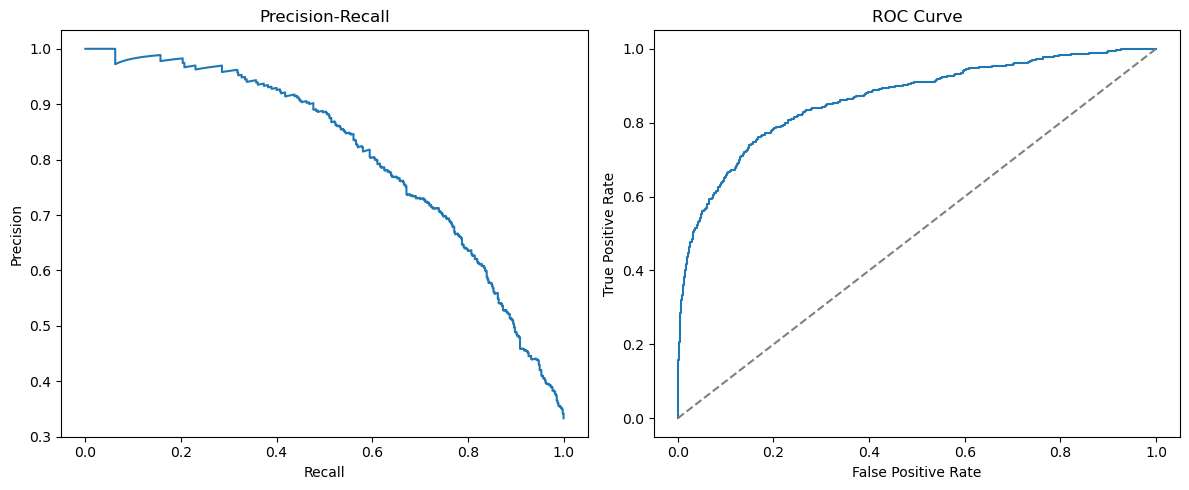

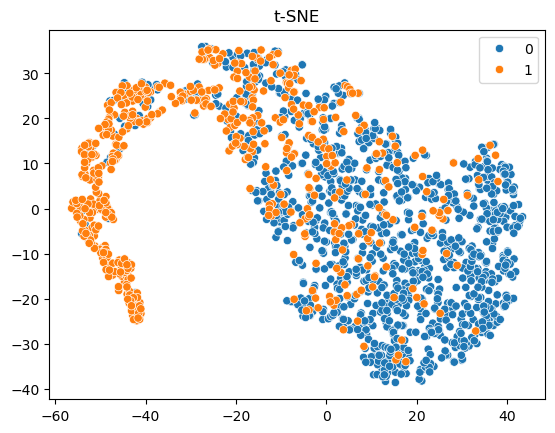

In [2]:
path = r"C:\afeca academy\סימסטר ב\advanced deep learning\project Normalizing Flow\MedlAnaomaly-Data\Camelyon16\Camelyon16"
train_ds = CamelyonDataset(os.path.join(path, 'train'), get_transforms(True))
test_ds = CamelyonDataset(os.path.join(path, 'test'), get_transforms(False))
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=4)
#model = MSFlow().cuda()
#loss_fn = CombinedLoss(center_weight=0.001, margin_weight=0.1, feat_dim=128*4).cuda()
#params = list(model.parameters()) + list(loss_fn.center.parameters())
#optimizer = torch.optim.Adam(params, lr=1e-4)
#print("Total train samples:", len(train_ds))
#print("Batch size:", train_loader.batch_size)
#print("Expected batches per epoch:", len(train_loader))
#for epoch in range(1, 20):
#    print(f"\nEpoch {epoch}")
#    train_epoch(model, train_loader, loss_fn, optimizer)
#torch.save(model.state_dict(), 'msflow_Glow_Focal_Center_margin_Loss_AugThreshold.pt')
#evaluate(model, test_loader)
model = MSFlow().cuda()
model.load_state_dict(torch.load("msflow_Glow_Focal_Center_margin_Loss_AugThreshold.pt"))
embeddings, preds, labels = evaluate(model, test_loader, threshold=0.35)
#best_th = find_best_threshold_by_precision(preds, labels, min_recall=0.5)
#evaluate_from_predictions(preds, labels, threshold=best_th)
